# Bayesian Changepoint Detection for Piecewise Datasets 

This code computes the probability of changepoints in a piecewise data sets. In this notebook example, I show you how to use it.

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

from bayesian_changepoint_detection.piecewise_change_functions import *

from bayesian_changepoint_detection.priors import const_prior
from functools import partial

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

from bayesian_changepoint_detection.x_index_averager import average_indices

%matplotlib inline

Use scipy logsumexp().


First let's generate some toy-data:

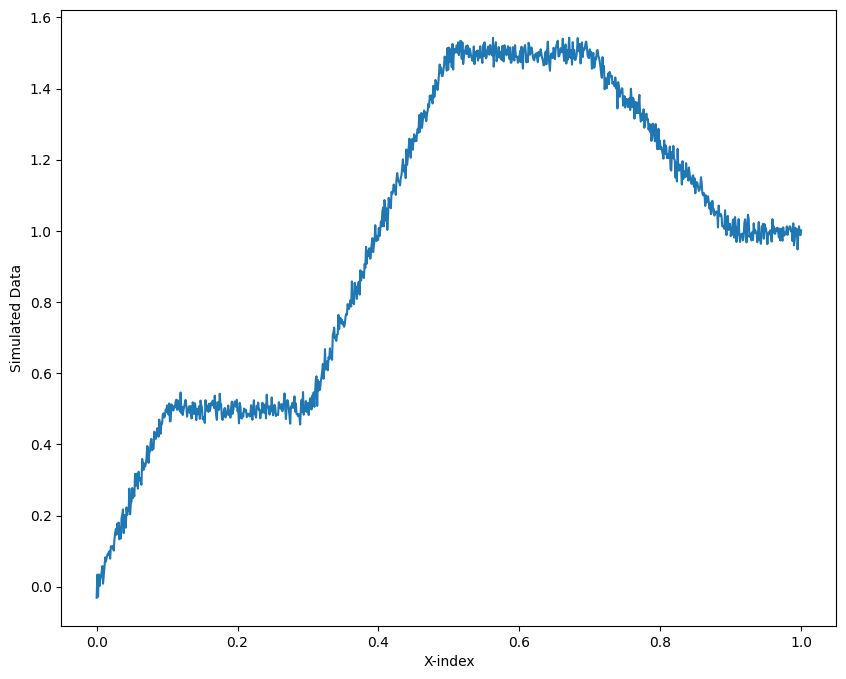

In [2]:
# Example of the simulated data
x = [[0, 0.1], [0.1, 0.3], [0.3, 0.5], [0.5, 0.7], [0.7, 0.9], [0.9, 1]]
y = [[0, 0.5], [0.5, 0.5], [0.5, 1.5], [1.5, 1.5], [1.5, 1], [1, 1]]

# You can tune the noise level to better simulate your real data
noise_stddev = 0.02

x_values, y_values = gradual_change_trace(x, y, noise_stddev)

plt.figure(figsize=(10,8))
plt.xlabel('X-index')
plt.ylabel('Simulated Data')
plt.plot(x_values, y_values)
plt.show()

For piecewise dataset, we need to do one step extra, step-ize the piecewise data by calculating the first derivative, before we apply the bayesian change-point detectionn method

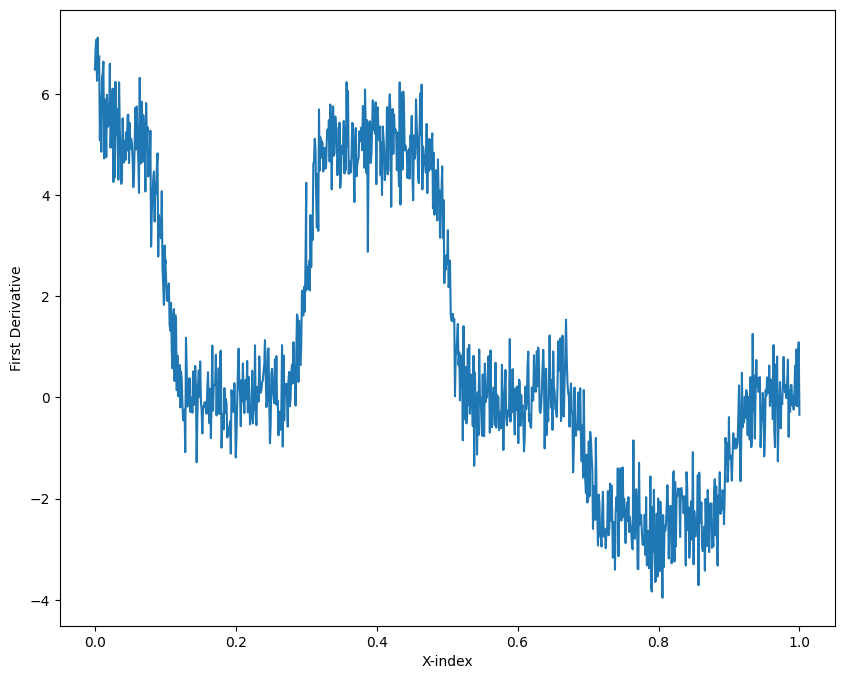

In [3]:
# set the window size and scaling factor to get step-like first-derivative trace
# Calculate the optimal window size based on the estimated noise standard deviation
window_size = optimal_window_size(estimate_noise_std(y_values, scaling_factor=1.3))
filtered_y_values = moving_window_filter(y_values, window_size)
# Calculate the filtered_y_values,first_derivative_values,fitted_y_values and plot the data
first_derivative_values = first_derivative(x_values, y_values, window_size)
# filtered_first_derivative = savgol_filter(first_derivative_values, window_length=5, polyorder=3)

data = first_derivative_values

plt.figure(figsize=(10,8))
plt.xlabel('X-index')
plt.ylabel('First Derivative')
plt.plot(x_values, data)
plt.show()

## Bayesian Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

Compute the likelihood of changepoints on data. `offline_changepoint_detection()`

    Parameters:
    Inputs:
        data    -- the time series data
        truncate  -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood

    Outputs:
        P  -- the log-likelihood of a datasequence [t, s], given there is no changepoint between t and s
        Q -- the log-likelihood of data
        Pcp --  the log-likelihood that the i-th changepoint is at time step t. To actually get the probility of a changepoint at time step t sum the probabilities.

The `offline_changepoint_detection()` function returns three things: `Q[t]`, the log-likelihood of data `[t, n]`, `P[t, s]`, the log-likelihood of a datasequence `[t, s]`, given there is no changepoint between `t` and `s` and `Pcp[i, t]`, the log-likelihood that the `i`-th changepoint is at time step `t`. To actually get the probility of a changepoint at time step `t` sum the probabilities.

In [4]:
# Let's start to analyze the trace, in this case the first derivative
prior_function = partial(const_prior, p=1/(len(data) + 1))
Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-50)

How does that look like for our toy-data?

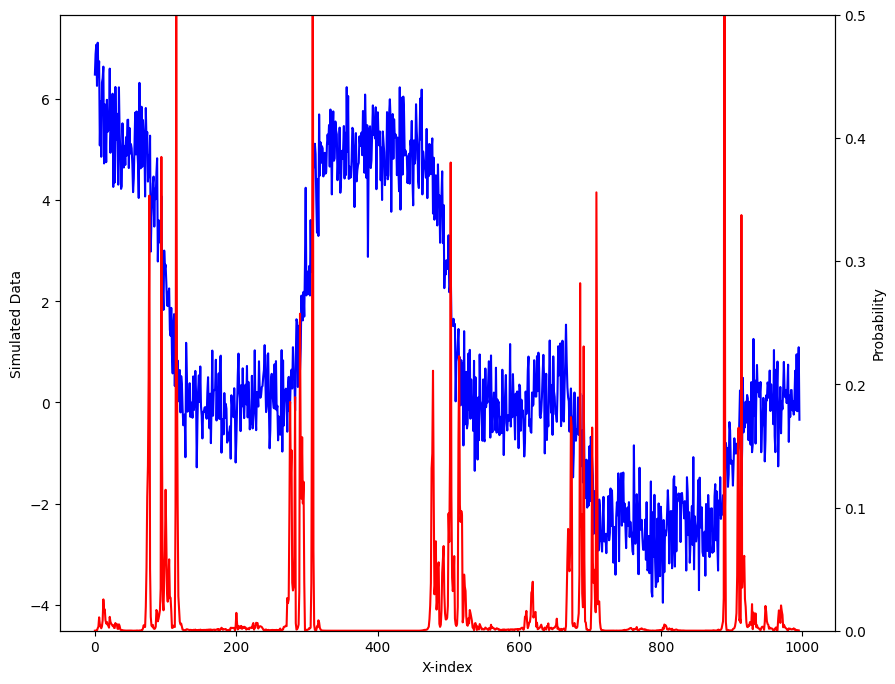

In [5]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot the data
ax1.plot(data[:], color='blue')
ax2.plot(np.exp(Pcp).sum(0), color='red')

# Set the y-limits for the second axis
ax2.set_ylim(0,0.5)

# Set the x-label and y-label for the first axis
ax1.set_xlabel('X-index')
ax1.set_ylabel('Simulated Data')

# Set the y-label for the second axis
ax2.set_ylabel('Probability')

# Show the plot
plt.show()

Before proceeding to further analysis, we need to filter those less probably based on our domain knowledge. We can tune the filter with two parameters. `prob_threshold` and `closeness_threshold`.
- `prob_threshold`: sets a threshold, only above which is considered as a real change-point; normally 0.1-0.2 works good. 
- `closeness_threshold`: sets a threshold, only wider than which is considered a new change-point, otherwise will be grouped and averaged into the previous one. 

In [11]:
# set your threshold here
prob_threshold = 0.1
closeness_threshold = 50

averaged_indices = average_indices(prob_threshold, closeness_threshold, Pcp)

for index in averaged_indices:
    print(index)


96
290
496
692
903
[96, 290, 496, 692, 903]


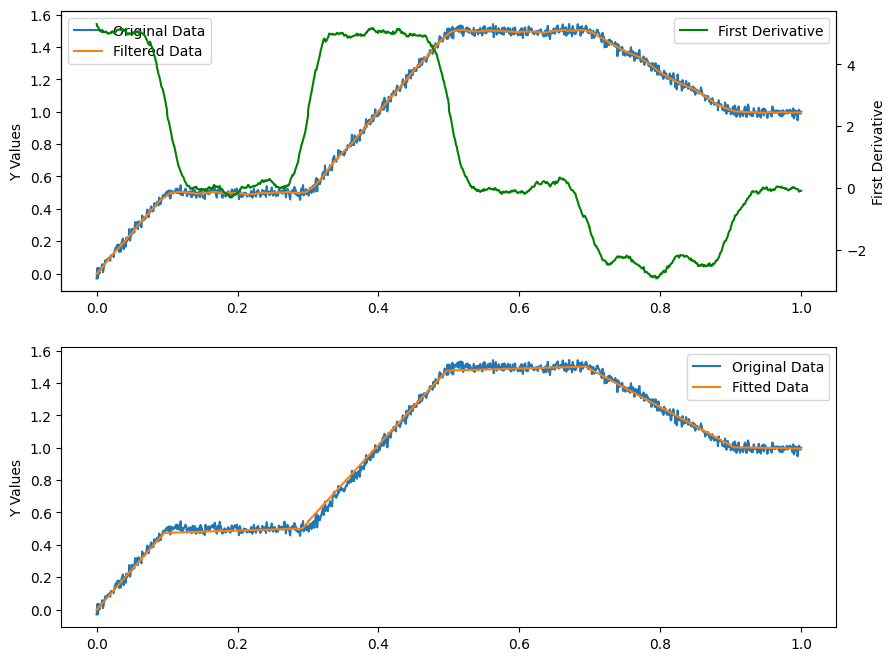

In [10]:
# Calculate the filtered_y_values,first_derivative_values,fitted_y_values and plot the data
filtered_y_values = moving_window_filter(y_values, window_size)
first_derivative_values = first_derivative(x_values, filtered_y_values, window_size)
fitted_y_values = reconstruct_fitted_data(x_values, filtered_y_values, averaged_indices)

plot_data(x_values, y_values, filtered_y_values, first_derivative_values, fitted_y_values)
plt.show()


That works pretty well, but is somewhat slow. It's possible to speed that up by truncating a sum in the algorithm. However that sometimes leeds to $\infty$ values. Set the `truncate` parameter to e.g. `-10` to test that out.                      